In [14]:
import richdem as rd
import geopandas as gpd
import rasterio
from rasterio.mask import mask

In [11]:
# Carregar feições
gdf = gpd.read_file('data/SIRGAS_GPKG_favela.gpkg')

/Users/fernandogomes/miniconda3/envs/favelavis/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(


In [13]:
gdf = gdf.loc[gdf.fv_nome == 'São Remo', :]

In [27]:
# --- 1. Caminho do raster e da geometria ---
raster_path = "../LiDAR_produtos/2017/MDT-2017-50cm.tiff"

# --- 2. Ler o polígono ---
geoms = gdf.geometry.buffer(200).envelope.values

In [28]:
# --- 3. Abrir e recortar o raster ---
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

In [29]:
# --- 4. Atualizar metadados ---
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# --- 5. Salvar o raster recortado ---
with rasterio.open("tmp/raster_recortado.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [30]:
# Carregar DEM
dem = rd.LoadGDAL("tmp/raster_recortado.tif")

In [31]:
dem

rdarray([[  0.     , 739.74854, 739.68176, ..., 735.27985, 735.312  ,
            0.     ],
         [  0.     , 739.7319 , 739.69336, ..., 735.2651 , 735.31244,
            0.     ],
         [  0.     , 739.6331 , 739.5885 , ..., 735.2637 , 735.3829 ,
            0.     ],
         ...,
         [  0.     , 758.4797 , 758.6043 , ..., 767.0326 , 767.09216,
            0.     ],
         [  0.     , 758.4186 , 758.52563, ..., 766.98676, 767.0053 ,
            0.     ],
         [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
            0.     ]], shape=(1589, 1654), dtype=float32)

In [35]:

# Preencher depressões
flow_dir = rd.FillDepressions(dem, epsilon=True)


A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 0.266352 s==================== ] (99% - 0.0s - 1 threads)20% - 0.2s - 1 threads)
m Cells processed = 2628206
m Cells in pits = 472240
W W In assigning negligible gradients to depressions, some depressions rose above the surrounding cells. This implies that a larger storage type should be used. The problem occured for 6348 of 2623278.


In [36]:
# Acumulação de fluxo
flow_acc = rd.FlowAccumulation(flow_dir, method='D8')


A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)=========                                       ] (23% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 748948
p Calculating flow accumulation...
t Wall-time       = 0.13465 s================ ] (99% - 0.0s - 1 threads)


In [37]:
# Salvar resultado
rd.SaveGDAL("tmp/flow_accumulation.tif", flow_acc)

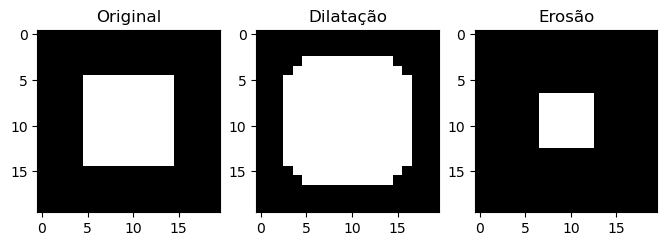

In [8]:
import numpy as np
from skimage.morphology import binary_dilation, binary_erosion, disk
import matplotlib.pyplot as plt

# Imagem sintética binária
image = np.zeros((20, 20), dtype=np.uint8)
image[5:15, 5:15] = 1

# Dilatação e Erosão
dilated = binary_dilation(image, footprint=disk(2))
eroded = binary_erosion(image, footprint=disk(2))

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(image, cmap='gray'); axes[0].set_title('Original')
axes[1].imshow(dilated, cmap='gray'); axes[1].set_title('Dilatação')
axes[2].imshow(eroded, cmap='gray'); axes[2].set_title('Erosão')
plt.show()